In [1]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [2]:
df = pd.read_csv("08.06.22.csv", index_col = 0)

Split into training and test data

In [3]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

Plot training and test data

Dimension of train data:  (4225, 31)
Dimension of test data:  (1057, 31)


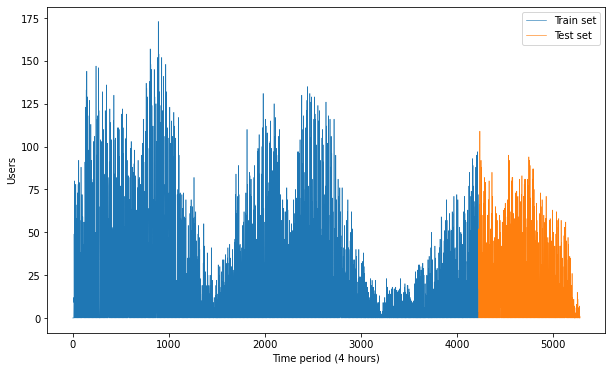

In [4]:
# Plot train and test data
plt.figure(figsize = (10, 6))
#plt.figure(figsize = (15, 6))

#Line width
lw = 0.6

sns.lineplot(x = train_dataset.index, y = train_dataset.Users, linewidth = lw)
sns.lineplot(x = test_dataset.index, y = test_dataset.Users, linewidth = lw)
plt.xlabel('Time (hour)')
plt.ylabel('Users')
plt.legend(['Train set', 'Test set'], loc='upper right')
plt.xlabel('Time period (4 hours)')

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

Dimension of train data:  (4225, 31)
Dimension of test data:  (1057, 31)


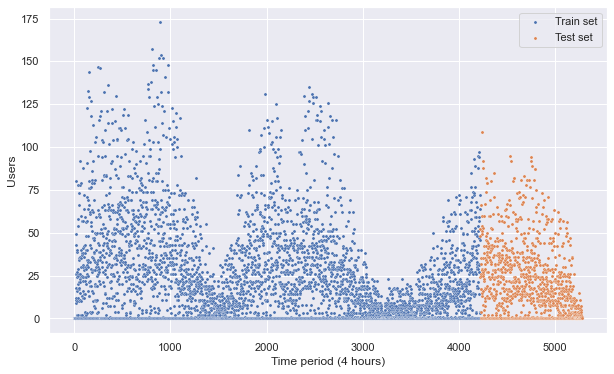

In [5]:
# Plot train and test data
sns.set(rc={'figure.figsize':(10,6)})
#plt.figure(figsize = (15, 6))

#Size of circles
Size = 10

sns.scatterplot(x = train_dataset.index, y = train_dataset.Users, s = Size)
sns.scatterplot(x = test_dataset.index, y = test_dataset.Users, s = Size)
plt.xlabel('Time (hour)')
plt.ylabel('Users')
plt.legend(['Train set', 'Test set'], loc='upper right')
plt.xlabel('Time period (4 hours)')

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [6]:
# Split train data to X and y
X_train = train_dataset.drop(['Users'], axis = 1)
y_train = train_dataset.loc[:,['Users']]

# Split test data to X and y
X_test = test_dataset.drop(['Users'], axis = 1)
y_test = test_dataset.loc[:,['Users']]

In [7]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [8]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

#Have set time steps to 12, equivalent of two days
TIME_STEPS = 12
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (1045, 12, 30)
y_train.shape:  (4213, 1)
X_test.shape:  (1045, 12, 30)
y_test.shape:  (4213, 1)


In [9]:
# Function for LSTM and GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    initializer = tf.keras.initializers.GlorotUniform()
    model.add(m (units = units, kernel_initializer=initializer))
    #model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = "sigmoid"))
    
    #opt = keras.optimizers.Adam(learning_rate=0.01)
    #Compile model
    model.compile(loss='mae', optimizer="adam")
    return model

# GRU and LSTM
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [10]:
# Fitting LSTM and GRU
def fit_model(model):
    earlystopping  = keras.callbacks.EarlyStopping(monitor = 'val_loss',
   
   #The patience for early stopping is set to 20 as the validation and training loss tends to zig zag.
                                               patience = 20)
    
    #Epochs at 150 is not too high considering the batch_size, steps_per_epoch and timestep set earlier.
    #Early stopping is meant to prevent overfitting.
    history = model.fit(X_train, y_train, epochs = 150,  
                        validation_split = 0.2, batch_size = 64, 
                        callbacks = [earlystopping],
                        steps_per_epoch = 16)
    return history
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/150
16/16 [==============================] - 1s 49ms/step - loss: 0.1868 - val_loss: 0.0782
Epoch 2/150
16/16 [==============================] - 0s 9ms/step - loss: 0.1363 - val_loss: 0.0768
Epoch 3/150
16/16 [==============================] - 0s 10ms/step - loss: 0.1210 - val_loss: 0.0731
Epoch 4/150
16/16 [==============================] - 0s 10ms/step - loss: 0.1218 - val_loss: 0.0774
Epoch 5/150
16/16 [==============================] - 0s 9ms/step - loss: 0.1127 - val_loss: 0.0698
Epoch 6/150
16/16 [==============================] - 0s 9ms/step - loss: 0.1068 - val_loss: 0.0646
Epoch 7/150
16/16 [==============================] - 0s 9ms/step - loss: 0.1013 - val_loss: 0.0558
Epoch 8/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0884 - val_loss: 0.0541
Epoch 9/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0720 - val_loss: 0.0452
Epoch 10/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0683 - val_loss: 0.0495
Epoch 

Epoch 20/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0573 - val_loss: 0.0534
Epoch 21/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0574 - val_loss: 0.0468
Epoch 22/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0579 - val_loss: 0.0465
Epoch 23/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0555 - val_loss: 0.0498
Epoch 24/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0478
Epoch 25/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0572 - val_loss: 0.0476
Epoch 26/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0536 - val_loss: 0.0475
Epoch 27/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0543 - val_loss: 0.0484
Epoch 28/150
16/16 [==============================] - 0s 9ms/step - loss: 0.0559 - val_loss: 0.0482
Epoch 29/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0505 - val_loss: 0.0508

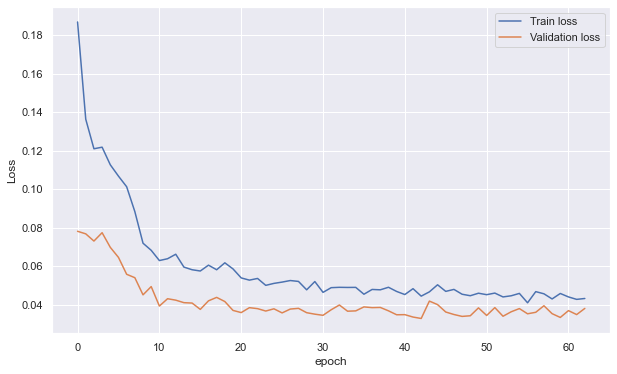

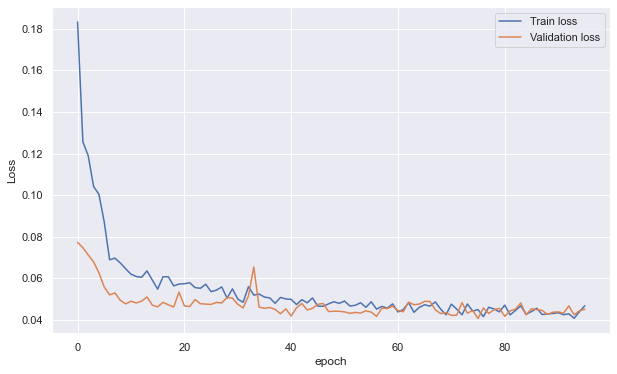

In [11]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_lstm)
plot_loss (history_gru)

In [12]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

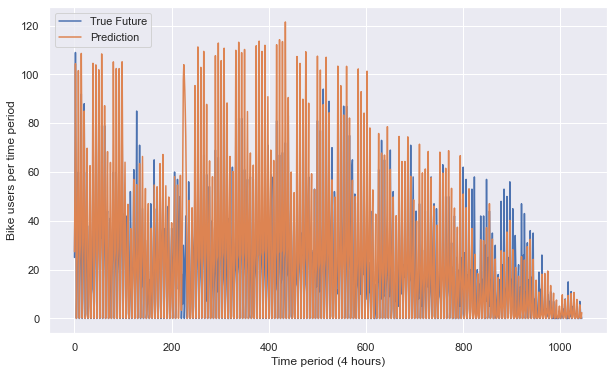

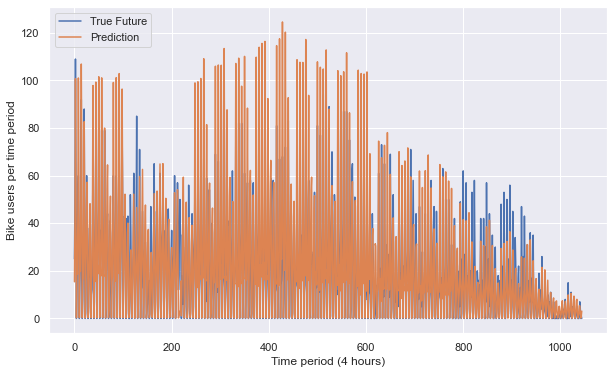

In [13]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
        
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')
    
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    
    plt.legend(loc='upper left')
    plt.xlabel('Time period (4 hours)')
    plt.ylabel('Bike users per time period')

plot_future(prediction_lstm, y_test)
plot_future(prediction_gru, y_test)

In [14]:
from prettytable import PrettyTable

def array_with_prediction(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    rsquared = r2_score(actual, predictions)
    array = np.array([mae, rmse, rsquared])
    return array
###########################################################################
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('R-squared: {:.4f}'.format(r2_score(actual, predictions)))
    print('')

evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')
################################################################################
lstm = array_with_prediction(prediction_lstm, y_test)
gru = array_with_prediction(prediction_gru, y_test)

LSTM:
Mean Absolute Error: 9.2199
Root Mean Square Error: 14.8410
R-squared: 0.4934

GRU:
Mean Absolute Error: 7.6342
Root Mean Square Error: 12.2480
R-squared: 0.6549



In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


X = df.drop(columns = ['Users'], axis = 1)
y = df["Users"]


X_train,X_test,y_train,y_test = train_test_split(X.values,y,test_size=0.20,random_state=0)

clf = RandomForestRegressor(n_estimators=1000,
            oob_score=True)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

evaluate_prediction(y_pred, y_test, 'RF')

RF:
Mean Absolute Error: 6.6263
Root Mean Square Error: 10.2364
R-squared: 0.8528



In [16]:
models = ["Metrics", "LSTM", "GRU", "RF"]
metrics = np.array(["MAE", "RMSE", "R-Squared"])

lstm = ["%.2f" % member for member in lstm]
gru = ["%.2f" % member for member in gru]
rf = array_with_prediction(y_pred, y_test)
rf = ["%.2f" % member for member in rf]

table = PrettyTable()

table.add_column(models[0], metrics)
table.add_column(models[1], lstm)
table.add_column(models[2], gru)
table.add_column(models[3], rf)


table

Metrics,LSTM,GRU,RF
MAE,9.22,7.63,6.63
RMSE,14.84,12.25,10.24
R-Squared,0.49,0.65,0.85


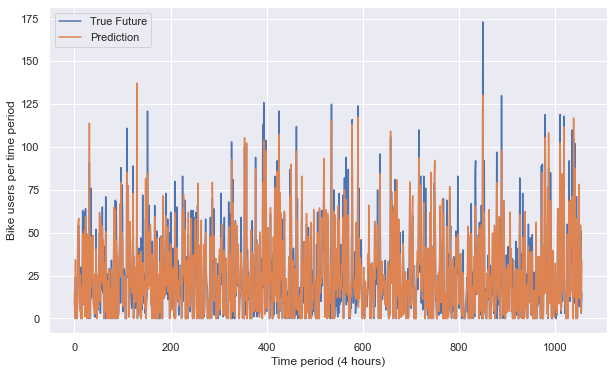

In [17]:
plot_future(y_pred, y_test)

In [18]:
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)

Plot distribution of RF

In [19]:
y_train = y_train.to_frame()
y_test["Data"] = "Test set"
y_train["Data"] = "Train set"


y1_Train = y_train.sort_index().reindex(list(range(0, 5282)), fill_value = 0)
y1_Test = y_test.sort_index().reindex(list(range(0, 5282)), fill_value = 0)

Observations in train data:  4225
Observations in test data:  1057


Text(0.5, 0, 'Time period (4 hours)')

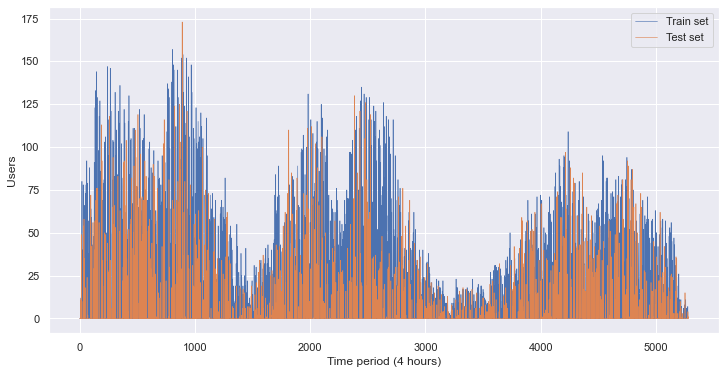

In [20]:
print('Observations in train data: ', y_train.shape[0])
print('Observations in test data: ', y_test.shape[0])

#Linewidth
lw = 0.6

#sns.rugplot(x = 'index', y = 'Users', ax = ax, hue = 'Data', 
#            data = combined.reset_index())
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x = 'index', y = 'Users', ax = ax, 
            data = y1_Train.reset_index(),
            legend='brief', label= "Train set", linewidth = lw)
sns.lineplot(x = 'index', y = 'Users', ax = ax, 
            data = y1_Test.reset_index(),
            legend='brief', label= "Test set", linewidth = lw)
plt.xlabel('Time period (4 hours)')
#plt.fill_between(combined.index, combined.Users)

In [21]:
vertical_stack = pd.concat([y_train, y_test], axis=0)
combined = vertical_stack.sort_index()


Observations in train data:  4225
Observations in test data:  1057


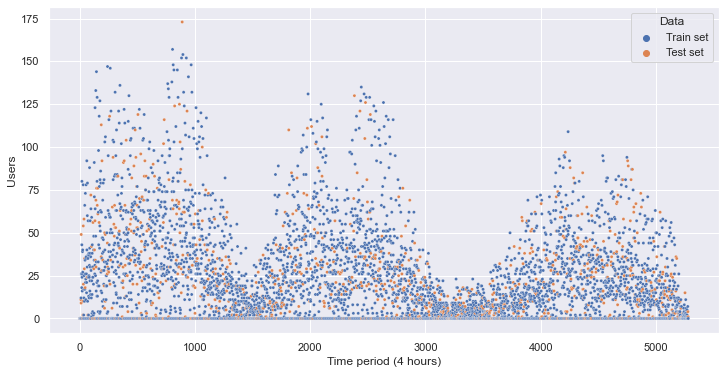

In [22]:
print('Observations in train data: ', y_train.shape[0])
print('Observations in test data: ', y_test.shape[0])

#Size of circles
size = 10

sns.set(rc={'figure.figsize':(10,6)})
fig, ax = plt.subplots(figsize=(12,6))
#sns.rugplot(x = 'index', y = 'Users', ax = ax, hue = 'Data', 
#            data = combined.reset_index())
g = sns.scatterplot(x = 'index', y = 'Users', ax = ax, hue = 'Data', 
            data = combined.reset_index(), s = size)
#plt.legend(labels = ['Train set', 'Test set'], loc='upper right')
#g.legend(['Train set', 'Test set'])
plt.xlabel('Time period (4 hours)')
plt.show(g)